In [ ]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import os, pickle
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

from itertools import product

import sys, os

import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P


num_data = 355504


np.random.seed(66)

def to_interval(istr):
    c_left = istr[0]=='['
    c_right = istr[-1]==']'
    closed = {(True, False): 'left',
              (False, True): 'right',
              (True, True): 'both',
              (False, False): 'neither'
              }[c_left, c_right]
    left, right = map(pd.to_datetime, istr[1:-1].split(','))
    return pd.Interval(left, right, closed)

re_split = False
frac = [0.4,0.2,0.4]
assert np.sum(frac) == 1
frac = np.cumsum(frac)
print (frac)
data_save_path= 'data/'

def sliding(gs, window_size = 6):
    npr_l = []
    for g in gs:
        npr = np.concatenate([np.zeros([window_size-1, g.shape[1]]),g])
        npr_l.append(sliding_window_view(npr, (window_size, g.shape[1])).squeeze(1))
    return np.vstack(npr_l)

[0.4 0.6 1. ]


# LOADING THE DATA

In [ ]:
# if re_split:


aggr_df = pd.read_csv('mimic_iv_hypotensive_cut2.csv',sep = ',', header = 0,converters={1:to_interval}).set_index(['stay_id','time']).sort_index()
# create action bins (four actions in total)
aggr_df['action'] = aggr_df['bolus(binary)']*2 + aggr_df['vaso(binary)']
all_idx = np.random.permutation(aggr_df.index.get_level_values(0).unique())
train_df = aggr_df.loc[all_idx[:int(len(all_idx)*frac[0])]].sort_index()
test_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[0]):int(len(all_idx)*frac[1])]].sort_index()
valid_df = aggr_df.loc[all_idx[int(len(all_idx)*frac[1]):]].sort_index()
# print (np.unique(train_df['action'],return_counts=True)[1]*1./len(train_df))
# pickle.dump([train_df, test_df, valid_df], open(data_save_path+'processed_mimic_hyp_2.pkl','wb'))
drop_columns = ['vaso(amount)','bolus(amount)',\
            'any_treatment(binary)','vaso(binary)','bolus(binary)']




# LOOKING AT THE DATA

In [ ]:
print(len(aggr_df))
aggr_df.head()

355504


creatinine  \
stay_id  time                                                     
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)         NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)         2.7   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)         NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)         NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)         NaN   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                       NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                       NaN   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                       NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                       NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                       NaN   

                                                     lactate  urine_output  \
stay_id  time                                                                
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)      NaN           NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)      NaN          40.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)      NaN         100.0   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)      1.7           NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)      NaN          40.0   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                       NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                      38.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                       NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                       NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                       NaN   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                        NaN   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                      114.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                        NaN   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                        NaN   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                        NaN   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                 61.0   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                 63.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                 99.0   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                 72.0   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                 70.0   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)                      56.0   
         [2186-04-12 04:49:00, 2186-04-12 05:49:00)                      46.0   
         [2186-04-12 05:49:00, 2186-04-12 06:49:00)                      75.0   
         [2186-04-12 06:49:00, 2186-04-12 07:49:00)                      55.5   
         [2186-04-12 07:49:00, 2186-04-12 08:49:00)                      53.0   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30001446 [2186-04-12 03:49:00, 2186-04-12 04:49:00)             

# Data for patient with hypotension, two treatment vasopressors and a bolus dose of epinephrine depending on certain features of the patient. In order to do IRL we need to discretize the action space:
* Action 0 = No treatment
* Action 1 = Vaso
* Action 2 = Bolus
* Action 3 = Vaso + Bolus



# We also need to do a bit of data cleaning such as taking care of missing values before running our algorithms on it

In [ ]:
# for now drop indicators about bolus and vaso
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)
valid_df = valid_df.drop(columns=drop_columns)

#### imputation
impute_table = pd.read_csv('mimic_iv_hypotensive_cut2_impute_table.csv',sep=',',header=0).set_index(['feature'])
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
valid_df = valid_df.fillna(method='ffill')




for f in impute_table.index:
    train_df[f] = train_df[f].fillna(value = impute_table.loc[f].values[0])
    test_df[f] = test_df[f].fillna(value = impute_table.loc[f].values[0])
    valid_df[f] = valid_df[f].fillna(value = impute_table.loc[f].values[0])


data_non_normalized_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).head(num_data).copy()


#### standard normalization ####
normalize_features = ['creatinine', 'fraction_inspired_oxygen', 'lactate', 'urine_output',
                  'alanine_aminotransferase', 'asparate_aminotransferase',
                  'mean_blood_pressure', 'diastolic_blood_pressure',
                  'systolic_blood_pressure', 'gcs', 'partial_pressure_of_oxygen']
mu, std = (train_df[normalize_features]).mean().values,(train_df[normalize_features]).std().values
train_df[normalize_features] = (train_df[normalize_features] - mu)/std
test_df[normalize_features] = (test_df[normalize_features] - mu)/std
valid_df[normalize_features] = (valid_df[normalize_features] - mu)/std




### create data matrix ####
X_train = train_df.loc[:,train_df.columns!='action']
y_train = train_df['action']

X_test = test_df.loc[:,test_df.columns!='action']
y_test = test_df['action']

X_valid = valid_df.loc[:, valid_df.columns!='action']
y_valid = valid_df['action']

In [ ]:
X_df = pd.concat([X_train, X_valid, X_test], axis=0, ignore_index=True).copy()
y_df = pd.concat([y_train, y_valid, y_test], axis=0, ignore_index=True).copy()


In [ ]:
data_df = pd.concat([train_df, valid_df, test_df], axis=0, ignore_index=False).copy()
# data_df = data_df.head(num_data).copy()
# X_df = X_df.head(num_data).copy()
# y_df = y_df.head(num_data).copy()


In [ ]:
print(len(data_df))
print(len(X_df))
print(len(y_df))
print(len(data_non_normalized_df))

355504
355504
355504
355504


# Normalized version of the data

In [ ]:
data_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)   -0.422008   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)   -0.422008   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)   -0.422008   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)   -0.422008   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)   -0.422008   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 -1.760743   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 -1.760743   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 -1.760743   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 -1.760743   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 -1.760743   

                                                      lactate  urine_output  \
stay_id  time                                                                 
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29) -0.182521     -0.225783   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29) -0.182521     -0.225783   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)  0.360532     -0.225783   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)  0.360532     -0.225783   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)  0.360532     -0.225783   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 -0.288689   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 -0.288689   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 -0.288689   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 -0.288689   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 -0.288689   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  -0.265706   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  -0.265706   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  -0.265706   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  -0.265706   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  -0.265706   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             0.404836   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)             0.404836   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)             0.404836   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)             0.404836   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)             0.404836   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  0.391566   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  0.391566   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  0.391566   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  0.391566   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  0.391566   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      

# Unormalized version of the data

In [ ]:
data_non_normalized_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)         1.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)         1.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)         1.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)         1.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)         1.0   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      0.21   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      0.21   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      0.21   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      0.21   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      0.21   

                                                     lactate  urine_output  \
stay_id  time                                                                
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      1.8          80.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)      1.8          80.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)      3.0          80.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)      3.0          80.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)      3.0          80.0   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      34.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      34.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      34.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      34.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      34.0   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                       40.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                       40.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                       40.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                       40.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                       40.0   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 77.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 77.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 77.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 77.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 77.0   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      59.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      59.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      59.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      59.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      59.0   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             

# Matrix form of the data (Normalized and features only)

In [ ]:
X_df.head()

,creatinine,fraction_inspired_oxygen,lactate,urine_output,alanine_aminotransferase,asparate_aminotransferase,mean_blood_pressure,diastolic_blood_pressure,systolic_blood_pressure,gcs,partial_pressure_of_oxygen,heart_rate,temperature,respiratory_rate
0,-0.422008,-1.760743,-0.182521,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,-0.186486,86.0,37.0,19.0
1,-0.422008,-1.760743,-0.182521,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,-0.186486,86.0,37.0,19.0
2,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0
3,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0
4,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0


# Corresponding output data for training BC (corresponding treatments for each data point in X_df)

In [ ]:
y_df.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: action, dtype: float64

# Clustering the feature space to extract a discrete state space form the clusters

In [ ]:
num_clusters = 100
kmeans = KMeans(n_clusters= num_clusters , random_state=0)
kmeans.fit(X_df)
# hac = AgglomerativeClustering(n_clusters=num_clusters, linkage='single')
# hac.fit(X_df)
# clustering = SpectralClustering(n_clusters=num_clusters, assign_labels='discretize', random_state=0)
# clustering.fit(X_df)
# dbs = DBSCAN(min_samples=50, algorithm='ball_tree')
# dbs.fit(X_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=100, random_state=0)

In [ ]:
# Looking at the values counts for each cluster

np.unique(kmeans.labels_, return_counts = True)[1]

array([1573, 5201, 4839, 6302,  755, 2624, 4282, 1152,  206, 2074, 5666,
       2005, 6163, 1005, 3104,  859, 5044, 3901, 1961, 7998, 5495, 3806,
       4191, 3170, 2419,  573, 1358,  721, 8024, 6950, 4028,  423, 7428,
       5084, 6395, 2433,  235, 4324, 7887, 2404, 4686, 8928, 1132,  100,
       3347,  608, 4564, 7711, 1162,  120,   18, 2624, 5086, 3867, 6196,
       1095,  955,  198,  917, 3480, 7076, 2589, 4021, 8352, 1976, 7861,
       1557, 5527, 1369, 4511, 2516, 1746,  560, 6902, 2894,  676, 1189,
       6226, 5385, 1181, 8436, 7384, 5240,  702, 4064, 3613, 1590, 6754,
       2498, 3158,    2, 2687,  283, 4901, 6062, 3146,  678, 3040, 8417,
       7879])

In [ ]:
counts = np.unique(kmeans.labels_, return_counts = True)[1]

In [ ]:
# Assigning each data point to a cluster

X_df['cluster'] = kmeans.labels_.copy()
data_df['cluster'] = kmeans.labels_.copy()
data_non_normalized_df['cluster'] = kmeans.labels_.copy()

In [ ]:
data_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)   -0.422008   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)   -0.422008   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)   -0.422008   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)   -0.422008   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)   -0.422008   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 -1.760743   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 -1.760743   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 -1.760743   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 -1.760743   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 -1.760743   

                                                      lactate  urine_output  \
stay_id  time                                                                 
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29) -0.182521     -0.225783   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29) -0.182521     -0.225783   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)  0.360532     -0.225783   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)  0.360532     -0.225783   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)  0.360532     -0.225783   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 -0.288689   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 -0.288689   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 -0.288689   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 -0.288689   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 -0.288689   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  -0.265706   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  -0.265706   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  -0.265706   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  -0.265706   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  -0.265706   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             0.404836   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)             0.404836   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)             0.404836   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)             0.404836   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)             0.404836   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                  0.391566   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                  0.391566   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                  0.391566   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                  0.391566   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                  0.391566   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      

In [ ]:
X_df.head()

,creatinine,fraction_inspired_oxygen,lactate,urine_output,alanine_aminotransferase,asparate_aminotransferase,mean_blood_pressure,diastolic_blood_pressure,systolic_blood_pressure,gcs,partial_pressure_of_oxygen,heart_rate,temperature,respiratory_rate,cluster
0,-0.422008,-1.760743,-0.182521,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,-0.186486,86.0,37.0,19.0,38
1,-0.422008,-1.760743,-0.182521,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,-0.186486,86.0,37.0,19.0,38
2,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0,38
3,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0,38
4,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0,38


In [ ]:
data_non_normalized_df.head()

creatinine  \
stay_id  time                                                     
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)         1.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)         1.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)         1.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)         1.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)         1.0   

                                                     fraction_inspired_oxygen  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      0.21   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      0.21   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      0.21   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      0.21   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      0.21   

                                                     lactate  urine_output  \
stay_id  time                                                                
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)      1.8          80.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)      1.8          80.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)      3.0          80.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)      3.0          80.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)      3.0          80.0   

                                                     alanine_aminotransferase  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      34.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      34.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      34.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      34.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      34.0   

                                                     asparate_aminotransferase  \
stay_id  time                                                                    
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                       40.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                       40.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                       40.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                       40.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                       40.0   

                                                     mean_blood_pressure  \
stay_id  time                                                              
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                 77.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                 77.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                 77.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                 77.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                 77.0   

                                                     diastolic_blood_pressure  \
stay_id  time                                                                   
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)                      59.0   
         [2139-10-06 11:40:29, 2139-10-06 12:40:29)                      59.0   
         [2139-10-06 12:40:29, 2139-10-06 13:40:29)                      59.0   
         [2139-10-06 13:40:29, 2139-10-06 14:40:29)                      59.0   
         [2139-10-06 14:40:29, 2139-10-06 15:40:29)                      59.0   

                                                     systolic_blood_pressure  \
stay_id  time                                                                  
30004811 [2139-10-06 10:40:29, 2139-10-06 11:40:29)             

# Converting the data into trajectories to input to an IRL algorithm Note this is the same format of trajectories we used for HW1 and HW2.

In [ ]:
unique_stay_ids = data_df.index.get_level_values('stay_id').unique()

trajectories = []


for stay_id in unique_stay_ids:


  states, actions = data_df.loc[stay_id]['cluster'], data_df.loc[stay_id]['action']

  trajectory = []
  for i in range(len(states) - 1):
    trajectory.append((states[i], int(actions[i]), states[i+1] ))

  trajectories.append(T.Trajectory(trajectory))

We need to store all possible terminal states from the trajectories list. (Needed to calculate the normalizing constant in MaxEnt)

In [ ]:
terminal_states = []

for traj in trajectories:
  terminal_states.append(traj._t[-1][-1])

terminal_states = list(set(terminal_states))

In [ ]:
terminal_states

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

# Distribution of the treatments given in our data. (Most of the time no treatment is given, might vary on depending on how you cluster the data)

In [ ]:
y_df.value_counts()

0.0    195786
1.0    135305
3.0     15978
2.0      8435
Name: action, dtype: int64

# BC Policy example

In [ ]:
# Convert states and actions to one-hot encoding
state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(num_clusters)])
action_encoder = OneHotEncoder(sparse=False, categories= [np.arange(4)])


states_onehot = state_encoder.fit_transform(X_df['cluster'].to_numpy().reshape(-1, 1))
actions_onehot = action_encoder.fit_transform(y_df.to_numpy().reshape(-1, 1))


# # Define neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(states_onehot.shape[1],)),
    tf.keras.layers.Dense(actions_onehot.shape[1], activation='softmax')  # Output layer with softmax for discrete actions
])

# # Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

# # Train the model
model.fit(states_onehot, actions_onehot,  epochs=5, batch_size=128)

# # Evaluate the model
test_loss = model.evaluate(states_onehot, actions_onehot)
print("Test Loss:", test_loss)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
2778/2778 [==============================] - 7s 2ms/step - loss: 0.9203 - accuracy: 0.5619
Epoch 2/5
2778/2778 [==============================] - 7s 2ms/step - loss: 0.9085 - accuracy: 0.5654
Epoch 3/5
2778/2778 [==============================] - 5s 2ms/step - loss: 0.9084 - accuracy: 0.5661
Epoch 4/5
2778/2778 [==============================] - 7s 2ms/step - loss: 0.9083 - accuracy: 0.5658
Epoch 5/5
11110/11110 [==============================] - 19s 2ms/step - loss: 0.9075 - accuracy: 0.5666
Test Loss: [0.9074665904045105, 0.5666040182113647]


In [ ]:
bc_policy = np.argmax(model.predict(state_encoder.transform(np.arange(num_clusters).reshape(-1, 1))), axis =1)
bc_policy

4/4 [==============================] - 0s 3ms/step


array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0])

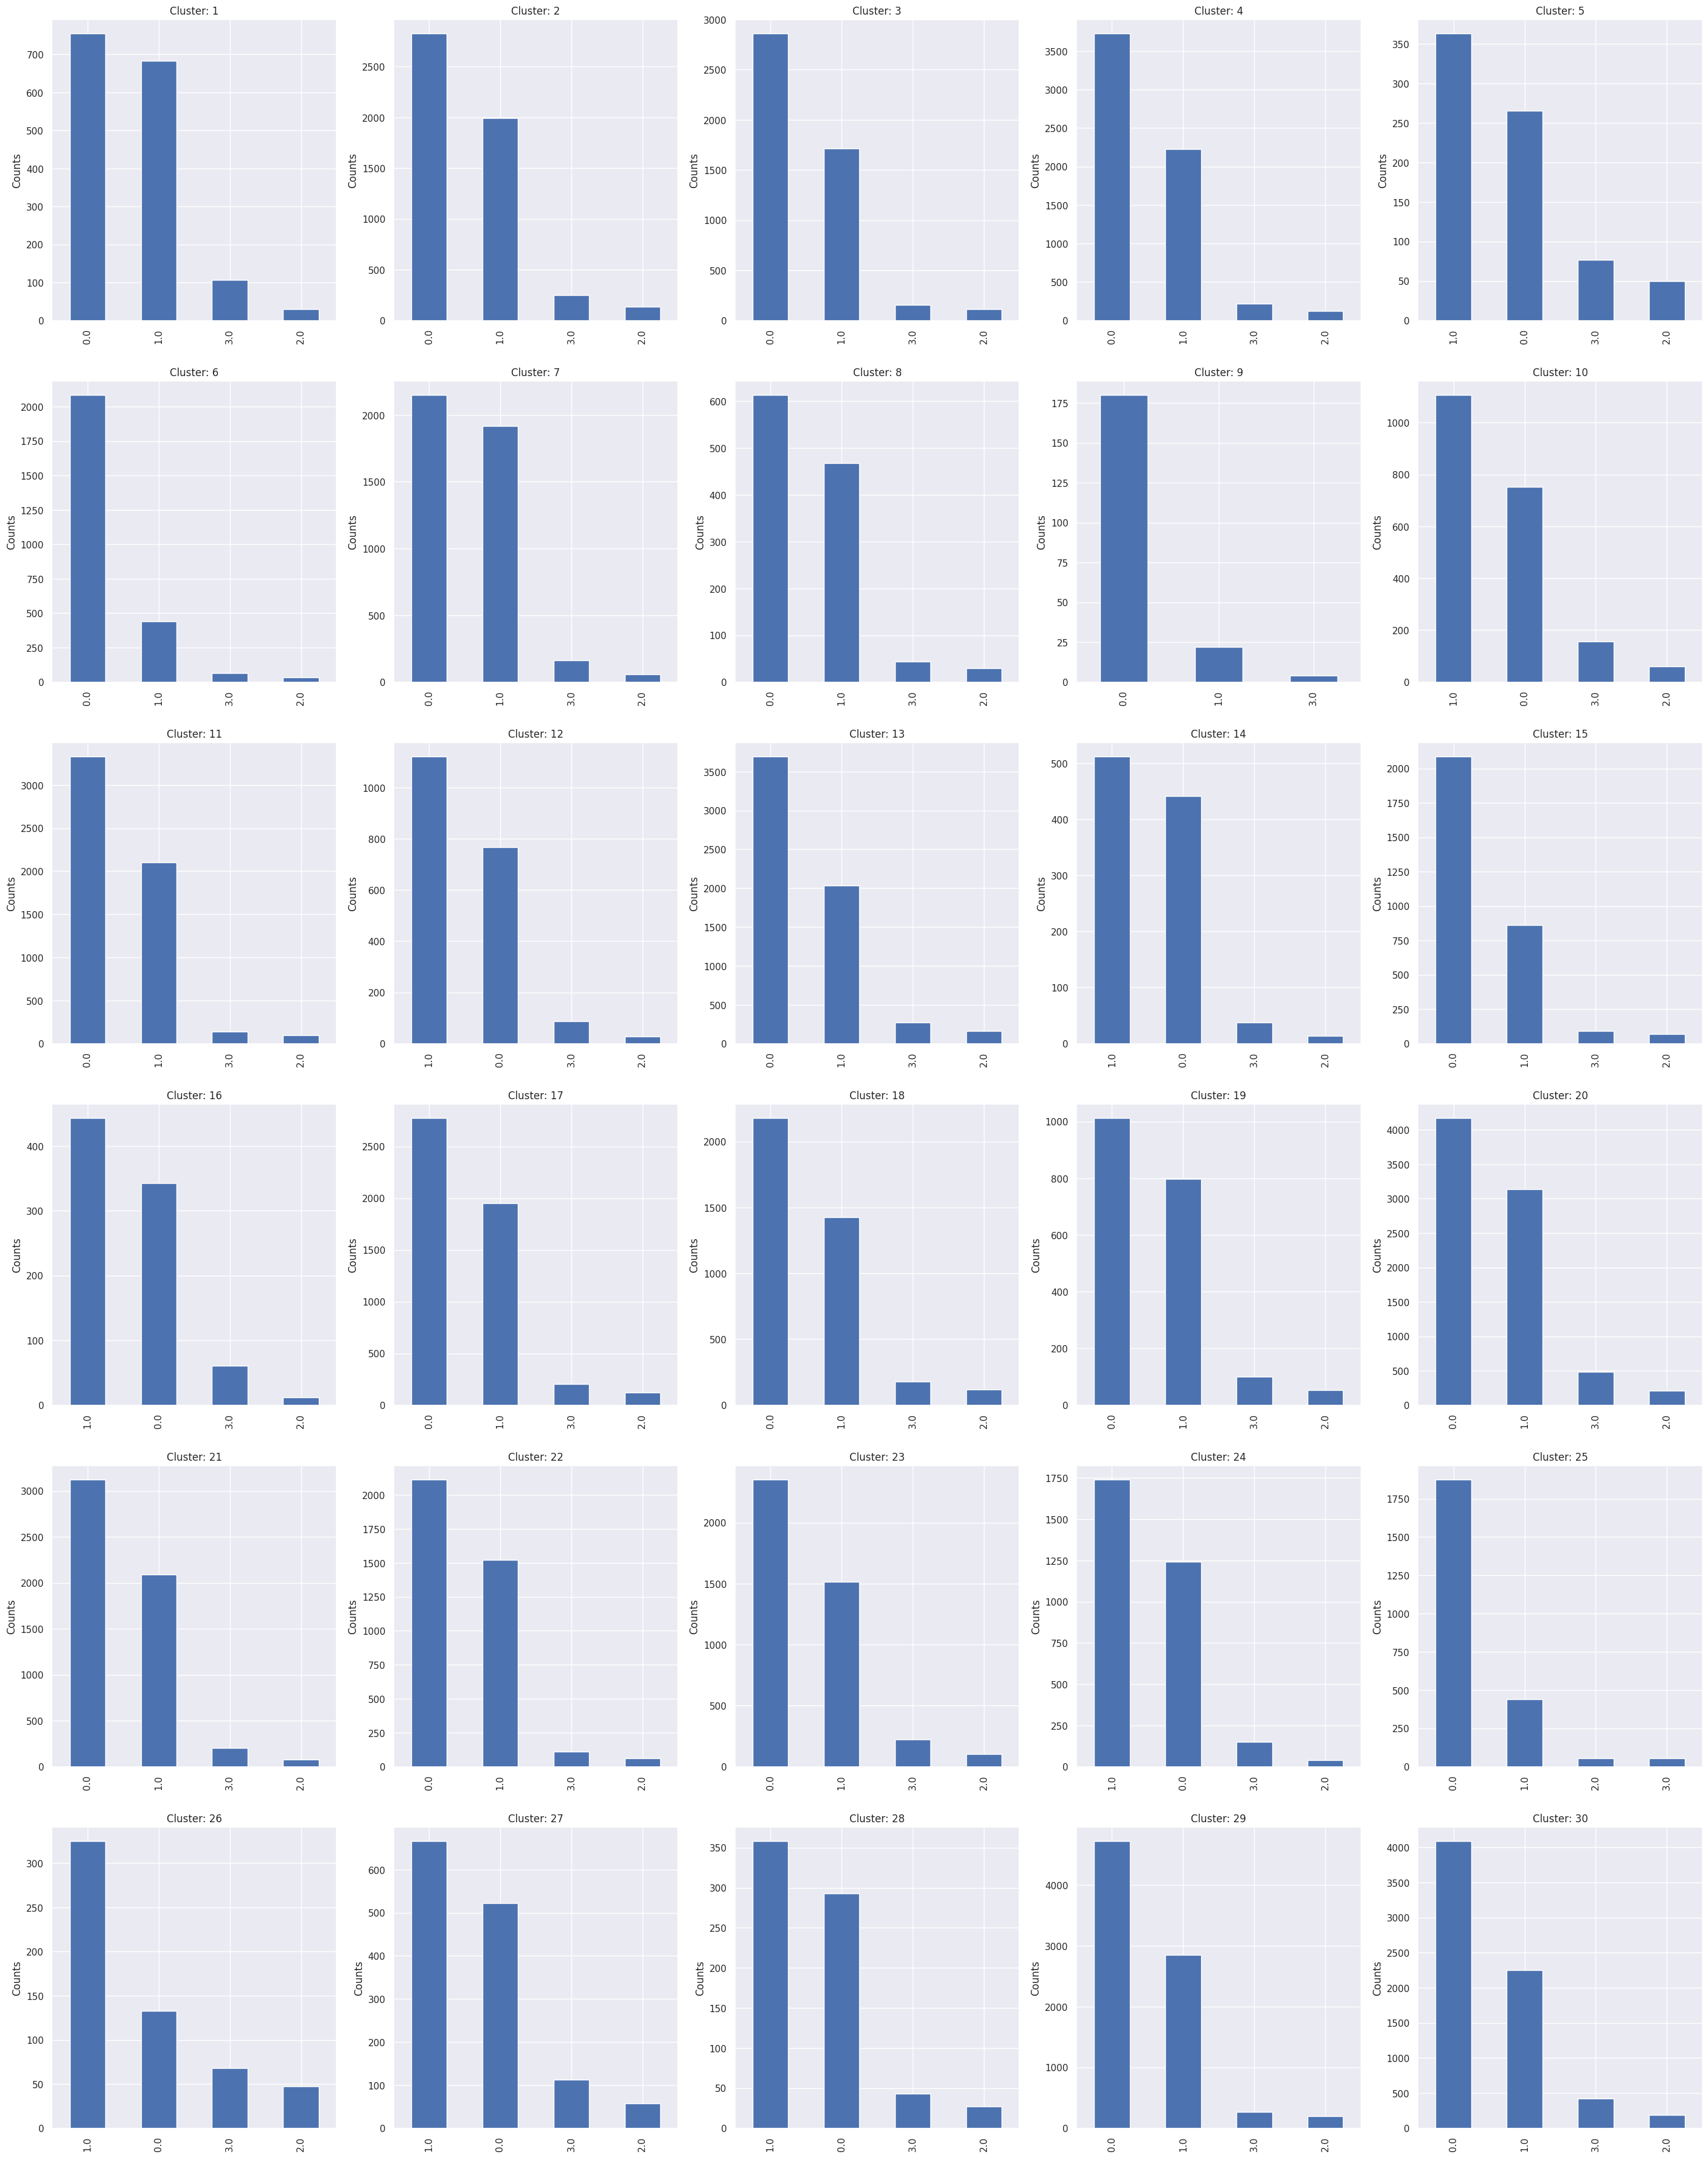

In [ ]:
sns.set()
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(35, 45))


for i, ax in enumerate(axes.flatten()):
    data_df[data_df['cluster'] == i]['action'].value_counts().plot(kind = 'bar', ax = ax, title = 'Cluster: ' + str(i+ 1))
    ax.set_ylabel('Counts')

# Estimating the Transition Dynamics using the MLE (feel free to play around with the smoothing_value)

In [ ]:
smoothing_value = 0.1

p_transition = np.zeros((num_clusters, num_clusters, 4)) + smoothing_value


for traj in trajectories:

  for tran in traj._t:

    p_transition[tran[0], tran[2], tran[1]] +=1

p_transition = p_transition/ p_transition.sum(axis = 1)[:, np.newaxis, :]

In [ ]:
p_transition

array([[[5.10119840e-01, 6.17196532e-01, 3.18421053e-01, 5.35344828e-01],
        [1.33155792e-04, 3.03468208e-03, 2.63157895e-03, 8.62068966e-04],
        [1.33155792e-04, 1.44508671e-04, 2.63157895e-03, 8.62068966e-04],
        ...,
        [1.33155792e-04, 1.58959538e-03, 2.63157895e-03, 8.62068966e-04],
        [4.12782956e-03, 3.03468208e-03, 2.63157895e-03, 2.67241379e-02],
        [6.79094541e-03, 1.31502890e-02, 2.63157895e-03, 9.48275862e-03]],

       [[3.61663653e-05, 5.04795558e-05, 6.94444444e-04, 3.83141762e-04],
        [2.42712477e-01, 2.38818778e-01, 1.18750000e-01, 2.26436782e-01],
        [7.59493671e-04, 5.04795558e-05, 6.94444444e-04, 3.83141762e-04],
        ...,
        [3.61663653e-05, 5.04795558e-05, 6.94444444e-04, 3.83141762e-04],
        [9.43942134e-03, 3.07925290e-03, 6.94444444e-04, 3.83141762e-04],
        [3.65280289e-03, 4.08884402e-03, 6.94444444e-04, 3.83141762e-04]],

       [[3.91877449e-04, 5.85480094e-05, 8.13008130e-04, 6.02409639e-04],
        

# Max Causal Entropy

# Feel free to play with the discount factor

In [ ]:
discount = 0.9

In [ ]:
from maxent import irl, irl_causal

In [ ]:
# set up features: we use one feature vector per state (1 hot encoding for each cluster/state)
features = state_encoder.transform(np.arange(num_clusters).reshape(-1, 1))

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

# actually do some inverse reinforcement learning
# reward_maxent = maxent_irl(p_transition, features, terminal_states, trajectories, optim, init, eps= 1e-3)

reward_maxent_causal = irl_causal(p_transition, features, terminal_states, trajectories, optim, init, discount,
               eps=1e-3, eps_svf=1e-4, eps_lap=1e-4)

In [ ]:
reward_maxent_causal

array([ 1.59204005,  4.61390294,  4.16548763,  6.40111401,  1.24726936,
        2.13771161,  3.53958997,  1.40704363,  1.05639668,  1.8285671 ,
        5.30574295,  1.80892632,  6.15091352,  1.34355441,  2.49165197,
        1.28562534,  4.39120632,  3.16418901,  1.78522977, 10.70452182,
        5.07089398,  3.07627282,  3.46096563,  2.53840192,  2.01752862,
        1.17997218,  1.48550616,  1.23648017, 10.6981049 ,  7.74356098,
        3.28701137,  1.13181455,  8.87270326,  4.49645668,  6.57227882,
        2.05045873,  1.07138827,  3.58775236, 10.30458797,  2.03575729,
        3.97515151, 13.94898144,  1.38776002,  1.02971125,  2.6928472 ,
        1.19816086,  3.83928071,  9.78079444,  1.40451475,  1.03290717,
        1.00510679,  2.15508248,  4.45485847,  3.10779226,  6.21021068,
        1.37906111,  1.32475449,  1.05576341,  1.30935442,  2.78229709,
        8.09976069,  2.14349304,  3.28504095, 11.92457167,  1.79381428,
       10.18174557,  1.58299668,  5.11977934,  1.49713508,  3.79

In [ ]:
rankings = np.argsort(reward_maxent_causal)
worst_clusters = {}
best_clusters = {}
for i in rankings[:5]:
  data = data_non_normalized_df[(data_non_normalized_df['cluster'] == i)]
  worst_clusters[i] = data.mean().to_dict()
for i in rankings[-5:][::-1]:
  data = data_non_normalized_df[(data_non_normalized_df['cluster'] == i)]
  best_clusters[i] = data.mean().to_dict()

In [ ]:
sorted_counts = []
for i in rankings[::-1]:
  sorted_counts.append(counts[i])
sorted_counts

[8928,
 8417,
 8436,
 8352,
 7998,
 8024,
 7887,
 7879,
 7861,
 7711,
 7428,
 7384,
 7076,
 6950,
 6902,
 6754,
 6395,
 6302,
 6226,
 6196,
 6163,
 6062,
 5666,
 5527,
 5495,
 5385,
 5240,
 5201,
 5084,
 5086,
 5044,
 4901,
 4839,
 4686,
 4564,
 4511,
 4324,
 4282,
 4191,
 4064,
 4028,
 4021,
 3901,
 3867,
 3806,
 3613,
 3480,
 3347,
 3158,
 3146,
 3170,
 3104,
 3040,
 2894,
 2687,
 2624,
 2589,
 2624,
 2516,
 2498,
 2433,
 2404,
 2419,
 2074,
 2005,
 1976,
 1961,
 1746,
 1590,
 1573,
 1557,
 1369,
 1358,
 1189,
 1181,
 1152,
 1162,
 1132,
 1095,
 1005,
 955,
 917,
 859,
 755,
 721,
 702,
 678,
 676,
 608,
 573,
 560,
 423,
 283,
 235,
 206,
 198,
 120,
 100,
 18,
 2]

In [ ]:
labels = worst_clusters[90].keys()
dict_consolidated = []
count = 0
best = list(rankings[-5:])[::-1]
worst = list(rankings[:5][::-1])
for i in best:
  print(i)
  for key, value in best_clusters[i].items():
    if key != 'cluster':
      dict_consolidated.append({'cluster': count, 'feature': key, "mean": value})
  count += 1
for i in worst:
  print(i)
  for key, value in worst_clusters[i].items():
    if key != 'cluster':
      dict_consolidated.append({'cluster': count, 'feature': key, "mean": value})
  count += 1

41
98
80
63
19
57
49
43
50
90


In [ ]:
rankings = np.argsort(reward_maxent_causal)
clusters = {}
for i in range(len(rankings)):
  cluster = rankings[i]
  data = data_non_normalized_df[(data_non_normalized_df['cluster'] == cluster)]
  clusters[cluster] = data.mean().to_dict()
  clusters[cluster]['cluster'] = 100 - i

full_dict_consolidated = []
for i in clusters:
  rank = clusters[i]['cluster']
  for key, value in clusters[i].items():
    full_dict_consolidated.append({'rank': rank, 'feature': key, "mean": value})

In [ ]:
full_dict_consolidated

[{'rank': 100, 'feature': 'creatinine', 'mean': 3.4},
 {'rank': 100, 'feature': 'fraction_inspired_oxygen', 'mean': 0.375},
 {'rank': 100, 'feature': 'lactate', 'mean': 5.300000000000001},
 {'rank': 100, 'feature': 'urine_output', 'mean': 37.5},
 {'rank': 100, 'feature': 'alanine_aminotransferase', 'mean': 105.5},
 {'rank': 100, 'feature': 'asparate_aminotransferase', 'mean': 140.5},
 {'rank': 100, 'feature': 'mean_blood_pressure', 'mean': 84.0},
 {'rank': 100, 'feature': 'diastolic_blood_pressure', 'mean': 71.5},
 {'rank': 100, 'feature': 'systolic_blood_pressure', 'mean': 114.0},
 {'rank': 100, 'feature': 'gcs', 'mean': 15.0},
 {'rank': 100, 'feature': 'partial_pressure_of_oxygen', 'mean': 265.0},
 {'rank': 100, 'feature': 'heart_rate', 'mean': 115.0},
 {'rank': 100, 'feature': 'temperature', 'mean': 38.349999999999994},
 {'rank': 100, 'feature': 'respiratory_rate', 'mean': 261.0},
 {'rank': 100, 'feature': 'action', 'mean': 1.0},
 {'rank': 100, 'feature': 'cluster', 'mean': 100},
 {

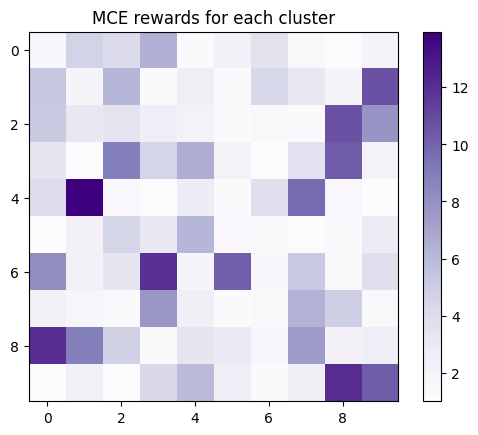

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sns.reset_orig()
data = reward_maxent_causal

# Reshape the data to a 10x10 2D array
data_2d = data.reshape((10, 10))

# Create a heatmap
plt.imshow(data_2d, cmap='Purples', interpolation='nearest')

# Optionally, add a colorbar to show the mapping between data values and colors
plt.colorbar()
plt.title('MCE rewards for each cluster')

# Show the plot
plt.show()


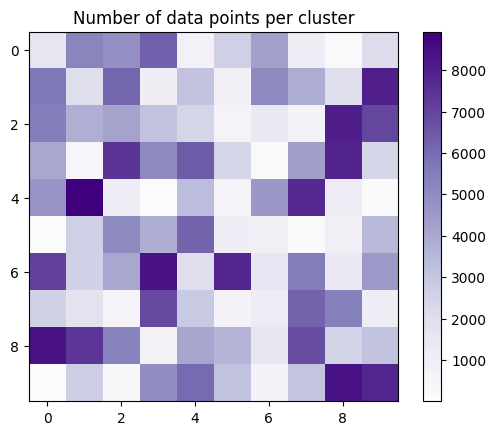

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.unique(kmeans.labels_, return_counts = True)[1]

data_2d = data.reshape((10, 10))

plt.imshow(data_2d, cmap='Purples', interpolation='nearest')
plt.colorbar()
plt.title('Number of data points per cluster')

plt.show()

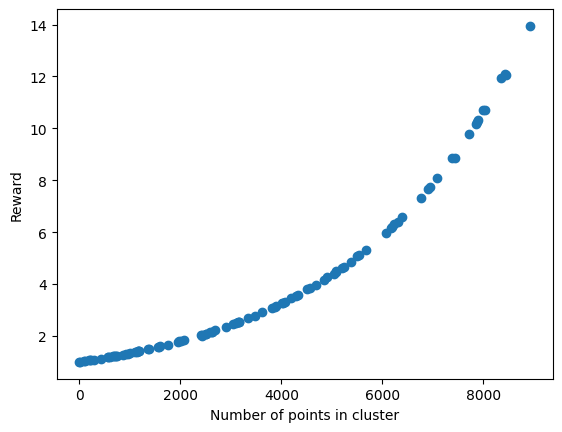

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.unique(kmeans.labels_, return_counts = True)[1]
y = reward_maxent_causal

plt.scatter(x,y)
plt.xlabel('Number of points in cluster')
plt.ylabel('Reward')

# Show the plot
plt.show()

<Axes: xlabel='cluster', ylabel='feature'>

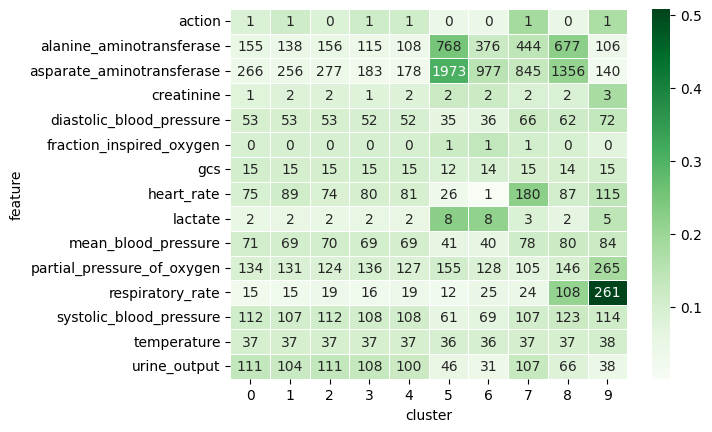

In [ ]:
import seaborn as sns

df = pd.DataFrame(dict_consolidated)
pivoted_df = df.pivot(index='feature', columns='cluster', values='mean')
pivoted_df_norm = (pivoted_df-pivoted_df.mean())/pivoted_df.std()
df_norm = pivoted_df.div(pivoted_df.sum(axis=1), axis=0)
sns.heatmap(df_norm, annot=pivoted_df, fmt=".0f", linewidths=0.5, cmap="Greens")

In [ ]:
import seaborn as sns

df = pd.DataFrame(full_dict_consolidated)
pivoted_df = df.pivot(index='feature', columns='rank', values='mean')

In [ ]:
new_df = pivoted_df.T
new_df["cluster"] = new_df.index
updated_new_df_1 = new_df.drop(['action', 'temperature', 'alanine_aminotransferase', 'asparate_aminotransferase', 'creatinine', 'fraction_inspired_oxygen', 'gcs', 'mean_blood_pressure', 'partial_pressure_of_oxygen', 'diastolic_blood_pressure'], axis=1)


In [ ]:
updated_new_df_1

feature,cluster,heart_rate,lactate,respiratory_rate,systolic_blood_pressure,urine_output
rank,,,,,,
1,1,75.441070,1.878916,15.108369,111.796905,111.101058
2,2,88.860577,2.050729,15.230973,107.226915,103.910637
3,3,74.428248,1.844194,19.119652,112.067637,111.110400
4,4,79.865272,1.959106,15.936630,108.164704,108.104286
5,5,80.944948,2.031345,18.997202,107.647958,100.218930
...,...,...,...,...,...,...
96,96,25.508345,8.227862,12.366378,60.872356,46.348485
97,97,1.459722,7.867917,24.871465,69.050694,31.433333
98,98,179.827602,3.190000,24.018176,107.051545,106.720000


In [ ]:
import plotly.express as px

In [ ]:
df = px.data.iris()
fig = px.parallel_coordinates(new_df, color="cluster", dimensions=["respiratory_rate", "asparate_aminotransferase", "alanine_aminotransferase", "systolic_blood_pressure", 'urine_output'], labels={"alanine_aminotransferase": "Alanine Aminotransferase",
                "creatinine": "Creatinine", "gcs": "GCS",
                "heart_rate": "Heart Rate", "respiratory_rate": "Respiratory Rate", "urine_output": "Urine Output", "partial_pressure_of_oxygen": "Partial Pressure of Oxygen"},
                             color_continuous_scale=px.colors.sequential.Bluered,
                             color_continuous_midpoint=50)
fig.show()

In [ ]:
px.scatter(
        new_df, y="alanine_aminotransferase", x="asparate_aminotransferase",
        color="cluster", color_continuous_scale=px.colors.sequential.Jet, )

In [ ]:
px.scatter_3d(new_df, x='asparate_aminotransferase', y='alanine_aminotransferase', z='urine_output',
              color='cluster', color_continuous_scale=px.colors.sequential.Bluered)

In [ ]:
import plotly.express as px

features = ['asparate_aminotransferase', 'respiratory_rate', 'heart_rate', 'urine_output']

fig = px.scatter_matrix(
    new_df,
    dimensions=features,
    color="cluster"
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

n_components = 4

updated_new_df = new_df.drop(['cluster'], axis=1)

pca = PCA(n_components=n_components)
components = pca.fit_transform(updated_new_df)

total_var = pca.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}

fig = px.scatter_matrix(
    components,
    color=range(1, 101),
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [ ]:
n_components = 2

updated_new_df = new_df.drop(['cluster'], axis=1)

pca = PCA(n_components=n_components)
components = pca.fit_transform(updated_new_df)

print(max(pca.components_[0]))

weighted_avg = pca.explained_variance_ratio_ @ np.abs(pca.components_)
most_important = weighted_avg.argsort()[::-1]

# most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_components)]
most_important_names = [updated_new_df.columns[most_important[i]] for i in range(len(weighted_avg))][:2]
most_important_names

0.9256774874288565


['asparate_aminotransferase', 'alanine_aminotransferase']

In [ ]:
pca.components_[0][2]/sum(pca.components_[0])

0.7122453025958361

In [ ]:
weighted_avg[1]/sum(weighted_avg)

0.28899737765922195

In [ ]:
weighted_avg, updated_new_df.columns

(array([4.64061933e-06, 3.78200257e-01, 9.24911020e-01, 2.60898347e-05,
        1.53409282e-04, 3.60902900e-06, 1.90071140e-05, 3.30563003e-04,
        2.36615986e-04, 3.22527075e-04, 7.29269255e-05, 2.70414896e-04,
        5.23055620e-04, 1.64532492e-05, 3.57269361e-03]),
 Index(['action', 'alanine_aminotransferase', 'asparate_aminotransferase',
        'creatinine', 'diastolic_blood_pressure', 'fraction_inspired_oxygen',
        'gcs', 'heart_rate', 'lactate', 'mean_blood_pressure',
        'partial_pressure_of_oxygen', 'respiratory_rate',
        'systolic_blood_pressure', 'temperature', 'urine_output'],
       dtype='object', name='feature'))

In [ ]:
weighted_avg = pca.explained_variance_ratio_ @ pca.components_
weighted_avg.argsort()

array([14, 12,  7,  9, 11,  4, 13,  0,  5,  6,  3, 10,  8,  1,  2])

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

features = most_important_names
X = updated_new_df[features]

pca = PCA(n_components=2)
components = pca.fit_transform(updated_new_df)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

fig = px.scatter(components, x=0, y=1, color=range(1, 101))

for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()

In [ ]:
!pip install dash
from dash import Dash, html, dcc, callback, Output, Input

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 20.3 MB/s eta 0:00:00


In [ ]:
from dash import Dash, dcc, html, Input, Output, callback
import plotly.express as px

import pandas as pd

app1 = Dash(__name__)

app1.layout = html.Div([
    html.Div([

        html.Div([
            dcc.Dropdown(
                new_df.columns.unique(),
                'respiratory_rate',
                id='xaxis-column'
            ),
        ], style={'width': '48%', 'display': 'inline-block'}),

        html.Div([
            dcc.Dropdown(
                new_df.columns.unique(),
                'heart_rate',
                id='yaxis-column'
            ),
        ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'})
    ]),

    dcc.Graph(id='indicator-graphic'),

])


@callback(
    Output('indicator-graphic', 'figure'),
    Input('xaxis-column', 'value'),
    Input('yaxis-column', 'value'))
def update_graph(xaxis_column_name, yaxis_column_name):

    fig = px.scatter(x=new_df[xaxis_column_name], y=updated_new_df[yaxis_column_name], color=range(1, 101))

    fig.update_layout(margin={'l': 40, 'b': 40, 't': 10, 'r': 0}, hovermode='closest')

    fig.update_xaxes(title=xaxis_column_name,
                     type='linear')

    fig.update_yaxes(title=yaxis_column_name,
                     type='linear')

    return fig


app1.run(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
from dash import Dash, dcc, html, Input, Output, callback
import plotly.express as px

import pandas as pd

app = Dash(__name__)

defaults = ["respiratory_rate", "asparate_aminotransferase", "alanine_aminotransferase", "systolic_blood_pressure", 'urine_output']

app.layout = html.Div([
    html.Div([

        html.Div([
            dcc.Dropdown(
                new_df.columns.unique(),
                value=defaults,
                multi=True,
                id='mulitple-select'
            ),
        ], style={'width': '100%', 'display': 'inline-block', 'margin': '10px'})
    ]),

    dcc.Graph(id='indicator-graphic'),

])


@callback(
    Output('indicator-graphic', 'figure'),
    Input('mulitple-select', 'value'))
def update_graph(values):

    fig = px.parallel_coordinates(new_df, color="cluster", dimensions=values, labels={"alanine_aminotransferase": "Alanine Aminotransferase",
                "creatinine": "Creatinine", "gcs": "GCS",
                "heart_rate": "Heart Rate", "respiratory_rate": "Respiratory Rate", "urine_output": "Urine Output", "partial_pressure_of_oxygen": "Partial Pressure of Oxygen"},
                             color_continuous_scale=px.colors.sequential.Bluered,
                             color_continuous_midpoint=50)

    return fig


app.run(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
x = list(rankings[:5])
list(rankings[-5:])[::-1] + list(rankings[:5][::-1])

[41, 98, 80, 63, 19, 57, 49, 43, 50, 90]

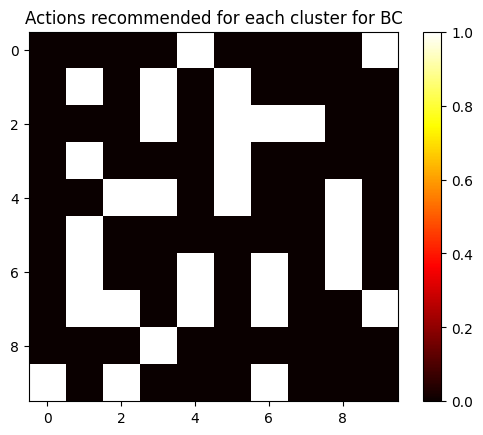

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = bc_policy

# Reshape the data to a 10x10 2D array
data_2d = data.reshape((10, 10))

# Create a heatmap
plt.imshow(data_2d, cmap='hot', interpolation='nearest')

# Optionally, add a colorbar to show the mapping between data values and colors
plt.colorbar()
plt.title('Actions recommended for each cluster for BC')

# Show the plot
plt.show()

# Computing the policy induced by your learnt reward

In [ ]:
V, Q = S.value_iteration(p_transition, reward_maxent_causal, discount)

In [ ]:
Q = Q.reshape((4, num_clusters))

In [ ]:
soft_pi_mce = (np.exp(Q)/ np.sum(np.exp(Q), axis = 0)).T

In [ ]:
soft_pi_mce

array([[0.40477713, 0.10604178, 0.33482395, 0.15435714],
       [0.24940282, 0.1844808 , 0.3625086 , 0.20360778],
       [0.17842349, 0.21386171, 0.14835224, 0.45936256],
       [0.36375376, 0.21974247, 0.27065086, 0.14585291],
       [0.3345322 , 0.10785702, 0.35919032, 0.19842046],
       [0.14701001, 0.3555665 , 0.10172466, 0.39569884],
       [0.36736452, 0.10137552, 0.32633506, 0.2049249 ],
       [0.16865064, 0.15730002, 0.48160814, 0.1924412 ],
       [0.04106014, 0.06408259, 0.69750963, 0.19734763],
       [0.27103026, 0.08537424, 0.48881795, 0.15477754],
       [0.4182357 , 0.19610335, 0.20328409, 0.18237685],
       [0.52464981, 0.07594572, 0.30044883, 0.09895564],
       [0.21336108, 0.17918639, 0.26823777, 0.33921475],
       [0.07562222, 0.06355962, 0.31156323, 0.54925493],
       [0.19907214, 0.17704937, 0.4552952 , 0.16858328],
       [0.14056102, 0.04649179, 0.72487938, 0.08806781],
       [0.29806636, 0.1906418 , 0.35255055, 0.15874129],
       [0.19079524, 0.12649709,

In [ ]:
policy_mce = np.argmax(Q, axis = 0).reshape(-1, )

In [ ]:
policy_mce

array([0, 2, 3, 0, 2, 3, 0, 2, 2, 2, 0, 0, 3, 3, 2, 2, 2, 3, 2, 1, 0, 2,
       3, 0, 1, 3, 3, 3, 1, 3, 0, 3, 2, 0, 3, 0, 1, 0, 3, 2, 0, 0, 2, 2,
       1, 2, 2, 1, 2, 2, 0, 0, 0, 3, 1, 3, 3, 2, 2, 3, 2, 0, 1, 1, 0, 1,
       0, 0, 2, 0, 1, 2, 2, 1, 0, 0, 0, 1, 2, 2, 3, 1, 0, 1, 2, 0, 2, 1,
       0, 2, 0, 2, 2, 0, 0, 0, 3, 3, 3, 1])

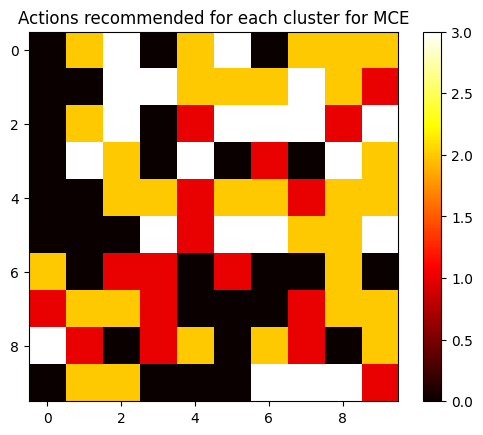

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = policy_mce

# Reshape the data to a 10x10 2D array
data_2d = data.reshape((10, 10))

# Create a heatmap
plt.imshow(data_2d, cmap='hot', interpolation='nearest')

# Optionally, add a colorbar to show the mapping between data values and colors
plt.colorbar()
plt.title('Actions recommended for each cluster for MCE')

# Show the plot
plt.show()